## Gate Cutting to Reduce Circuit Width

In this tutorial we will simulate expectation values of a four-qubit circuit using only two-qubit experiments by cutting gates in the circuit.

Like any circuit knitting technique, gate cutting can be described as three consecutive steps:

- **cut** some non-local gates in the circuit and possibly separate the circuit into subcircuits
- **execute** many sampled subexperiments using the Qiskit Sampler primitive
- **reconstruct** the expectation value of the full-sized circuit

### Create a circuit to cut

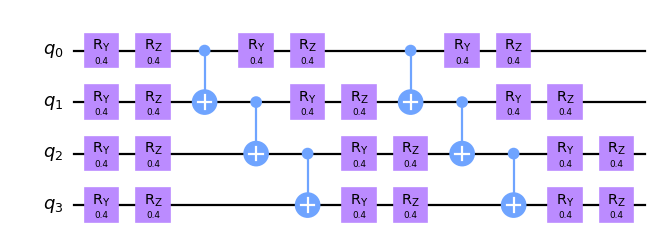

In [1]:
from qiskit.circuit.library import EfficientSU2

circuit = EfficientSU2(4, entanglement="linear", reps=2).decompose()
circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)

circuit.draw("mpl", scale=0.8)

### Specify some observables

Currently, only `Pauli` observables with phase equal to 1 are supported. Full support for `SparsePauliOp` is expected in CKT v0.5.0.

In [2]:
from qiskit.quantum_info import PauliList

observables = PauliList(["ZZII", "IZZI", "IIZZ", "XIXI", "ZIZZ", "IXIX"])

### Separate the circuit and observables according to a specified qubit partitioning

Each label in `partition_labels` corresponds to the `circuit` qubit in the same index. Qubits sharing a common partition label will be grouped together, and non-local gates spanning more than one partition will be cut.

In [3]:
from circuit_knitting.cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=circuit, partition_labels="AABB", observables=observables
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

### Visualize the decomposed problem

In [4]:
subobservables

{'A': PauliList(['II', 'ZI', 'ZZ', 'XI', 'ZZ', 'IX']),
 'B': PauliList(['ZZ', 'IZ', 'II', 'XI', 'ZI', 'IX'])}

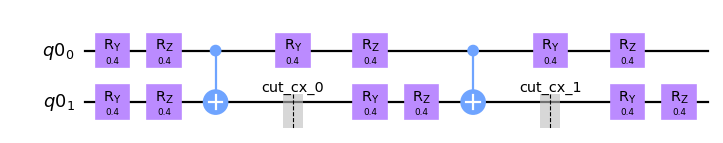

In [5]:
subcircuits["A"].draw("mpl", scale=0.8)

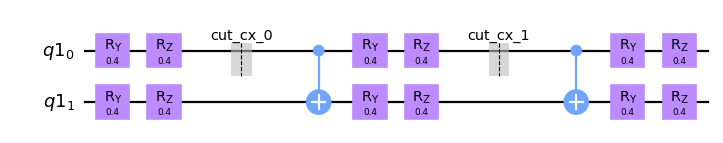

In [6]:
subcircuits["B"].draw("mpl", scale=0.8)

### Calculate the sampling overhead for the chosen cuts

Here we cut two CNOT gates, resulting in a sampling overhead of $9^2$.

For more on the sampling overhead incurred by circuit cutting, refer to the [explanatory material](../explanation/index.rst).

In [7]:
import numpy as np

print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 81.0


### Generate the subexperiments to run on the backend

`generate_cutting_experiments` accepts `circuits`/`observables` args as dictionaries mapping qubit partition labels to the respective `subcircuit`/`subobservables`.

To simulate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends. The number of samples taken from the distribution is controlled by `num_samples`, and one combined coefficient is given for each unique sample. For more information on how the coefficients are calculated, refer to the [explanatory material](../explanation/index.rst).

In [8]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

### Run the subexperiments using the Qiskit Sampler primitive

In [9]:
from qiskit_aer.primitives import Sampler

# Set up a Qiskit Aer Sampler primitive for each circuit partition
samplers = {
    label: Sampler(run_options={"shots": 2**12}) for label in subexperiments.keys()
}

# Retrieve results from each partition's subexperiments
results = {
    label: samplers[label].run(subexperiments[label]).result()
    for label in samplers.keys()
}

To use the Qiskit Runtime Sampler, replace the code above with this commented block.

In [10]:
# from qiskit_ibm_runtime import Session, Options, Sampler

# with Session(backend="ibmq_qasm_simulator") as session:
# Set up Qiskit Runtime Sampler primitives.
# samplers = {
#    label: Sampler(run_options={"shots": 2**12}) for label in subexperiments.keys()
# }

# Retrieve results from each subexperiment
# results = {
#    label: samplers[label].run(subexperiments[label]).result()
#    for label in samplers.keys()
# }

# session.close()

### Reconstruct the expectation values

Use the subexperiment results, subobservables, and sampling coefficients to reconstruct the expectation value of the original circuit.

Include the number of bits used for cutting measurements in the results metadata. This will be automated in a future release, but users must specify it manually for now.

In [11]:
from circuit_knitting.cutting import reconstruct_expectation_values

for label in subexperiments.keys():
    for i in range(len(subexperiments[label])):
        results[label].metadata[i]["num_qpd_bits"] = len(
            subexperiments[label][i].cregs[0]
        )

reconstructed_expvals = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)

### Compare the reconstructed expectation values with the exact expectation values from the original circuit

In [12]:
from qiskit_aer.primitives import Estimator

estimator = Estimator(run_options={"shots": None}, approximation=True)
exact_expvals = (
    estimator.run([circuit] * len(observables), list(observables)).result().values
)
print(
    f"Reconstructed expectation values: {[np.round(reconstructed_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Exact expectation values: {[np.round(exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Errors in estimation: {[np.round(reconstructed_expvals[i]-exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)
print(
    f"Relative errors in estimation: {[np.round((reconstructed_expvals[i]-exact_expvals[i]) / exact_expvals[i], 8) for i in range(len(exact_expvals))]}"
)

Reconstructed expectation values: [0.3988595, 0.50818366, 0.56561273, 0.13221407, 0.23711491, -0.14263326]
Exact expectation values: [0.36916216, 0.52511814, 0.59161991, 0.10927476, 0.28001606, -0.12940509]
Errors in estimation: [0.02969734, -0.01693448, -0.02600718, 0.02293931, -0.04290116, -0.01322817]
Relative errors in estimation: [0.08044524, -0.0322489, -0.04395927, 0.20992327, -0.15320963, 0.10222298]


In [13]:
import qiskit.tools.jupyter  # noqa: F401

%qiskit_version_table